# 加载并查看数据
## 加载数据

In [38]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import jieba
train = pd.read_csv("./data/train.csv", sep="###__###",header = None,index_col=False)
train.columns = ['ID', 'Age', 'Gender', 'Education', 'Query_List']
print(train.size)
train.head(1)

500000


,ID,Age,Gender,Education,Query_List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...


In [3]:
test = pd.read_csv("./data/test.csv", sep="###__###",header = None)
test.columns = ['ID', 'Query_List']
test.head(1)

,ID,Query_List
0,ED89D43B9F602F96D96C25255F7C228C,陈学冬将出的作品\t刘昊然与谭松韵\t211学校的分数线\t谁唱的味道好听\t吻戏是真吻还是...


## 设置全局参数

In [72]:
# 全局参数
%matplotlib inline
n=300
dimension = 'Age'
vocab_size=5000
qlen=400
slen=25
input_length=400
input_dim=5000
output_dim=100
class_num=6
batch_size=8
epochs=4

## 思路

不同特征的用户，搜索的信息不同

直接相关的线索：语义向量的聚类，主题，

### 执行计划

先走通流程

1. 用少量数据训练模型，调参，评估
1. 保存预处理数据和训练模型
1. 优化，降噪，增加数据

### 优化

特征工程

1. 文本结构
1. 情感分析
1. 有效文本长度比重

### 降噪
1. 自定义停用词
1. 不合理的用户（比如未成年博士）

# BOW模型

分词工具

https://github.com/fxsjy/jieba

https://github.com/thunlp/THULAC-Python

https://github.com/tsroten/pynlpir

https://github.com/rockyzhengwu/FoolNLTK

https://github.com/baidu/lac

https://github.com/hankcs/HanLP

https://github.com/isnowfy/snownlp

同义词替换

https://github.com/fighting41love/funNLP

https://github.com/huyingxi/Synonyms

近义词聚类

https://github.com/RaRe-Technologies/gensim


## 预处理
去除无关文本，每个分类特征，取n条数据，放到一个数组里

### 去停用词
https://github.com/goto456/stopwords

### 自定义停用词
jieba.load_userdict('stopwords/my_stopwords.txt')

In [74]:
import jieba.analyse as analyse
from collections import Counter
import random 

stopwords = pd.read_csv('./stopwords/cn_stopwords.txt',names=['sw'],index_col=False)

def cut(line,stopwords):
    segs=jieba.lcut(line)
    segs = list(filter(lambda x:len(x)>1, segs)) #没有解析出来的过滤掉
    segs = list(filter(lambda x:x not in stopwords, segs)) #把停用词过滤掉
    return segs

def preprocess(n,dimension): 
    t=[]
    t2=[]
    vocab=[]
    clist = list(set(train[dimension]))
    # 去掉无意义的 0 分类
    clist.pop(0)
    for c in clist:
        # 每个类别取 n 条数据
        lines = train[train[dimension]==c]['Query_List'][:n]
        for line in lines:
            try:
                line=re.sub(r'http\S+\s','http',line)
                line=re.sub(r' ','空格',line)
                segs=cut(line,stopwords)
                t.append((" ".join(segs),c))
                for q in line.split('\t'):
                    t2.append((" ".join(cut(q,stopwords)),c))
                vocab.extend(segs)
            except Exception as e:
                print(e)
                continue
    random.shuffle(t)
    random.shuffle(t2)
    return t,t2,vocab

def get_word2id(vocab,vocab_size):
    counter = Counter(vocab)
    count_pairs = counter.most_common(vocab_size)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
#     words = ['<PAD>'] + list(words)
    # open_file(vocab_file, mode='w').write('\n'.join(words) + '\n')
    word2id = dict(zip(words, range(len(words))))
    return word2id

t,t2,vocab=preprocess(n,dimension)
word2id=get_word2id(vocab,vocab_size)

In [75]:
import matplotlib.pyplot as plt
import pickle

def dump(obj,path):
    with open(path,"wb") as f:
        pickle.dump(obj,f)
        
def load(obj,path):
    with open(path,"wb") as f:
        pickle.load(obj,f)
        
def plot_loss_acc(history,model_name):
    plt.switch_backend('agg')

    fig1 = plt.figure()
#     plt.subplot(1,3,1)
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves : '+model_name,fontsize=16)
    fig1.savefig(model_name+'_loss.png')
    
    fig2 = plt.figure()
#     plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : '+model_name,fontsize=16)
    fig2.savefig(model_name+'_loss.png')
    plt.show()

## 分类函数

以分词字典的词频为特征，就是BOW模型。

向量为One-hot

In [8]:
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score

class TextClassifier():

    def __init__(self, classifier=MultinomialNB(),vectorizer = CountVectorizer(ngram_range=(1,4))):
        self.classifier = classifier
        self.vectorizer = vectorizer

    def features(self, X):
        return self.vectorizer.transform(X)

    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)

    def predict(self, x):
        return self.classifier.predict(self.features([x]))

    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

    def save_model(self, path):
        dump((self.classifier, self.vectorizer), path)

    def load_model(self, path):
        self.classifier, self.vectorizer = load(path)
        
    def cv(self, X, y, kf=StratifiedKFold(n_splits=5, shuffle=True)):
        y_pred = y[:]
        for i, j in kf.split(X, y):
            self.classifier.fit(X[i], y[i])
            y_pred[j]=self.classifier.predict(X[j])
        return y_pred
    
    def cv_score(self,y,y_pred):
        return precision_score(y, y_pred, average='macro')


### MultinomialNB，CountVectorizer（默认）

In [9]:
c = TextClassifier()
X,y = zip(*t)
x_train,x_test,y_train,y_test=train_test_split(X,y)
c.fit(x_train,y_train)
print(c.score(x_test,y_test))
c.save_model("models/gxli_MNB_CV_"+dimension)
#     c.load_model("gxli_MNB_C.model")
y_pred=c.cv(c.features(X),np.array(y))
print(precision_score(y,y_pred, average='macro'))

0.35333333333333333
0.39643047806560666


### TfidfVector

In [10]:
c = TextClassifier(vectorizer=TfidfVectorizer())
X,y = zip(*t)
x_train,x_test,y_train,y_test=train_test_split(X,y)
c.fit(x_train,y_train)
print(c.score(x_test,y_test))
c.save_model("models/gxli_MNB_TV_"+dimension)
#     c.load_model("gxli_MNB_T.model")
y_pred=c.cv(c.features(X),np.array(y))
print(precision_score(y,y_pred, average='macro'))

0.3333333333333333
0.31420877264753594


### SVM

In [12]:
from sklearn.svm import SVC

c = TextClassifier(classifier=SVC(), vectorizer=TfidfVectorizer())
X,y = zip(*t)
x_train,x_test,y_train,y_test=train_test_split(X,y)
c.fit(x_train,y_train)
print(c.score(x_test,y_test))
c.save_model("models/gxli_SVC_TV_"+dimension)
#     c.load_model("gxli_SVC_T.model")
y_pred=c.cv(c.features(X),np.array(y))
print(precision_score(y,y_pred, average='macro'))

0.30666666666666664
0.39068817379854187


# 主题模型

## LDA
1. 先训练lda主题模型
1. 把词向量转化成主题向量,构造中间层特征（部分解决了近义词与多义词的语义特征）
1. 分类

### 训练LDA模型

保存

In [13]:
X,y = zip(*t)
# 把每个用户的输入数据转换为二维列表
lda_data=[x.split(' ') for x in list(X)]

In [14]:
# from gensim import corpora, models, similarities
import gensim

id2word = gensim.corpora.Dictionary(lda_data)
corpus = [id2word.doc2bow(x) for x in lda_data]

lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=1000)
lda.save('models/gxli_lda')

### 用分类模型分类

X格式：浮点数二维列表

y格式：整数

#### 决策树

In [23]:
from sklearn import tree

lda = gensim.models.ldamodel.LdaModel.load('models/gxli_lda')

X=[]
y=[]
for x,_ in t:
    bow = id2word.doc2bow(x.split(' '))
    ndarray = lda.inference([bow])[0][0]
    X.append(ndarray.tolist())
    y.append(_)
x_train,x_test,y_train,y_test=train_test_split(X,y)
c=TextClassifier(classifier=tree.DecisionTreeClassifier())
c.classifier.fit(x_train,y_train)
print(c.classifier.score(x_test,y_test))
c.save_model("models/gxli_lda_dt_"+dimension)
#     c.load_model("models/gxli_lda_dt_"+dimensions[i])
y_pred=c.cv(np.array(X),np.array(y))
print(precision_score(y,y_pred, average='macro'))

0.23555555555555555
0.3416438530050198


#### 神经网络(损失和准确率待议)

In [33]:
import tensorflow as tf

X=[]
y=[]
for x,_ in t:
    bow = id2word.doc2bow(x.split(' '))
    ndarray = lda.inference([bow])[0][0]
    X.append(ndarray.tolist())
    y.append(_-1)
x_train,x_test,y_train,y_test=train_test_split(X,y)
nn=[tf.keras.layers.Dense(n,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2()) for n in [600,60,6]]
model=tf.keras.models.Sequential(nn)
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(x_train,y_train,batch_size=8,epochs=4,validation_freq=20)
# plot_loss_acc(history,'NN-'+dimension)
model.summary()

Train on 1350 samples
Epoch 1/4
1350/1350 [==============================] - 1s 533us/sample - loss: 8.1285 - sparse_categorical_accuracy: 0.1548
Epoch 2/4
1350/1350 [==============================] - 1s 376us/sample - loss: 5.0148 - sparse_categorical_accuracy: 0.1526
Epoch 3/4
1350/1350 [==============================] - 0s 368us/sample - loss: 3.4318 - sparse_categorical_accuracy: 0.1481
Epoch 4/4
1350/1350 [==============================] - 0s 369us/sample - loss: 2.6273 - sparse_categorical_accuracy: 0.1622
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  600600    
_________________________________________________________________
dense_9 (Dense)              multiple                  36060     
_________________________________________________________________
dense_10 (Dense)             multiple                  366      

# DL模型
## FastText
### 监督学习

In [35]:
import fasttext
s = set()
f = 'gxli_fasttext_train_'+dimension
with open(f, 'w', encoding='utf-8') as out:
    for x,_ in t:
        out.write('__label__'+dimension+str(_)+' , '+x+"\n")
classifier = fasttext.train_supervised(input=f, dim=100, epoch=5,lr=0.1, wordNgrams=2, loss='softmax')
classifier.save_model('models/gxli_fasttext_'+dimension)
result = classifier.test(f)
print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.3338888888888889
R@1: 0.3338888888888889
Number of examples: 1800


### 无监督学习

## TextCNN

### 定义网络结构

In [37]:
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

# class TextCNN(Model):
#     def __init__(self,maxlen, input_dim, output_dim,
#                  class_num=5,
#                  kernel_size=[3,4,5],
#                  last_activation='softmax'):
#         super(TextCNN, self).__init__()
#         self.eb=Embedding(input_dim, output_dim, input_length=maxlen)
#         self.gp=GlobalMaxPooling1D()
#         self.cc=Concatenate()
#         self.dn=Dense(class_num, activation=last_activation)
#         self.ks=kernel_size
#         self.c1=[Conv1D(128, k, activation='relu') for k in kernel_size]
#     def call(self, x):
#         convs = []
#         for c in self.c1:
#             c = c(self.eb(x))
#             c = self.gp(c)
#             convs.append(c)
#         x = self.cc(convs)
#         y = self.dn(x)
#         return y

In [64]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, input_dim, output_dim,
                 class_num=2,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))
        embedding = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen)(inputs)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs, outputs)
        return model

### 数据处理

In [68]:
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


d=[]
for x,y in t:
    s=[word2id.get(w,0) for w in x.split(' ') ]
    d.append((s,y-1))

X,y=zip(*d)
X=sequence.pad_sequences(X, input_length=maxlen)
y=to_categorical(y)
x_train,x_test,y_train,y_test=train_test_split(X,y)

# print(x_train.shape)
# print(x_train[0])

### 训练

In [69]:
model = TextCNN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))
    

训练...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1336/1350 [============================>.] - ETA: 0s - loss: 1.7842 - accuracy: 0.1901
Epoch 00001: saving model to ./cnn_model.h5
1350/1350 [==============================] - 5s 3ms/sample - loss: 1.7836 - accuracy: 0.1896 - val_loss: 1.7411 - val_accuracy: 0.2333
Epoch 2/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.5494 - accuracy: 0.4561
Epoch 00002: saving model to ./cnn_model.h5
1350/1350 [==============================] - 4s 3ms/sample - loss: 1.5499 - accuracy: 0.4548 - val_loss: 1.6719 - val_accuracy: 0.3000
Epoch 3/4
1328/1350 [============================>.] - ETA: 0s - loss: 1.1822 - accuracy: 0.7297
Epoch 00003: saving model to ./cnn_model.h5
1350/1350 [==============================] - 4s 3ms/sample - loss: 1.1775 - accuracy: 0.7333 - val_loss: 1.6384 - val_accuracy: 0.3000
Epoch 4/4
1344/1350 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.9397
Epoch 00004: saving mo

### 指标

In [76]:
plot_loss_acc(history,'CNN')

### 模型结构

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 100)     500000      input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 398, 128)     38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 397, 128)     51328       embedding_2[0][0]                
____________________________________________________________________________________________

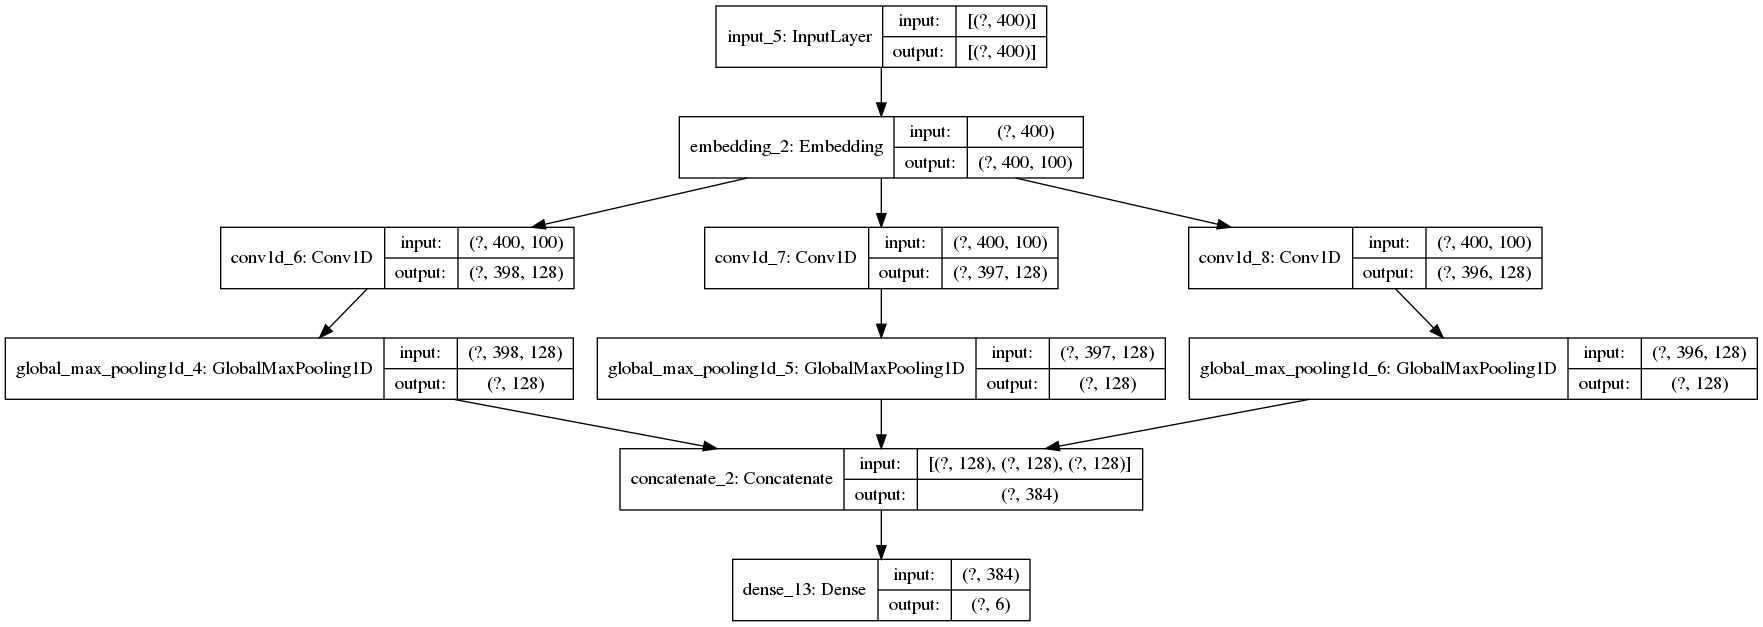

In [71]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## TextRNN
### 定义网络结构

In [77]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM


class TextRNN(object):
    def __init__(self, maxlen, input_dim, output_dim,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))

        embedding = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen)(inputs)
        x = LSTM(128)(embedding)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

### 训练

In [79]:
model = TextRNN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./rnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

训练...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.7907 - accuracy: 0.1652
Epoch 00001: saving model to ./rnn_model.h5
1350/1350 [==============================] - 28s 21ms/sample - loss: 1.7908 - accuracy: 0.1644 - val_loss: 1.7617 - val_accuracy: 0.2111
Epoch 2/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.6015 - accuracy: 0.3884
Epoch 00002: saving model to ./rnn_model.h5
1350/1350 [==============================] - 29s 22ms/sample - loss: 1.6022 - accuracy: 0.3874 - val_loss: 1.8478 - val_accuracy: 0.2222
Epoch 3/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.2070 - accuracy: 0.5565
Epoch 00003: saving model to ./rnn_model.h5
1350/1350 [==============================] - 30s 22ms/sample - loss: 1.2072 - accuracy: 0.5556 - val_loss: 2.1273 - val_accuracy: 0.2222
Epoch 4/4
1344/1350 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.7879
Epoch 00004: sav

### 指标

In [87]:
plot_loss_acc(history,'RNN')

### 模型结构

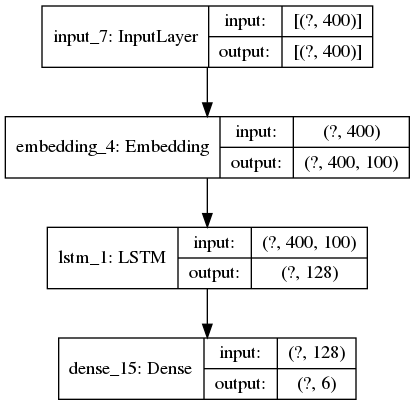

In [81]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Text-bi-RNN
### 定义网络结构

In [88]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM

class TextBiRNN(object):
    def __init__(self, maxlen, input_dim, output_dim,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))

        embedding = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen)(inputs)
        #x = Bidirectional(CuDNNLSTM(128))(embedding)
        x = Bidirectional(LSTM(128))(embedding)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

### 训练

In [89]:
model = TextBiRNN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./birnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

训练...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.7952 - accuracy: 0.1763
Epoch 00001: saving model to ./birnn_model.h5
1350/1350 [==============================] - 39s 29ms/sample - loss: 1.7950 - accuracy: 0.1778 - val_loss: 1.7973 - val_accuracy: 0.1378
Epoch 2/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.6810 - accuracy: 0.3244
Epoch 00002: saving model to ./birnn_model.h5
1350/1350 [==============================] - 41s 30ms/sample - loss: 1.6805 - accuracy: 0.3244 - val_loss: 1.7635 - val_accuracy: 0.2511
Epoch 3/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.1559 - accuracy: 0.6071
Epoch 00003: saving model to ./birnn_model.h5
1350/1350 [==============================] - 41s 30ms/sample - loss: 1.1552 - accuracy: 0.6081 - val_loss: 1.8997 - val_accuracy: 0.2600
Epoch 4/4
1344/1350 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.8527
Epoch 0000

### 指标

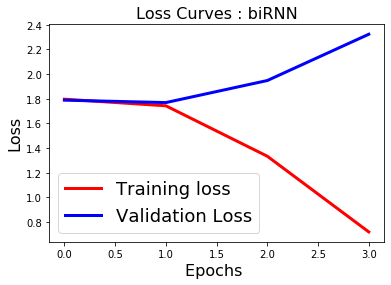

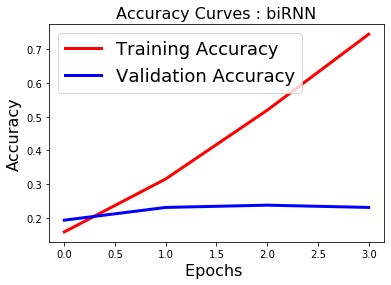

In [134]:
plot_loss_acc(history,'biRNN')

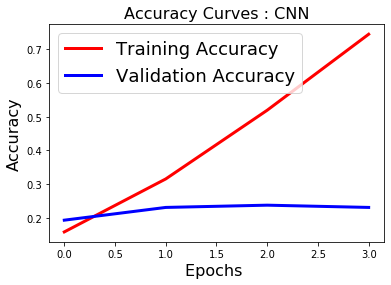

In [122]:
plot_acc(history,'biRNN')

### 模型结构

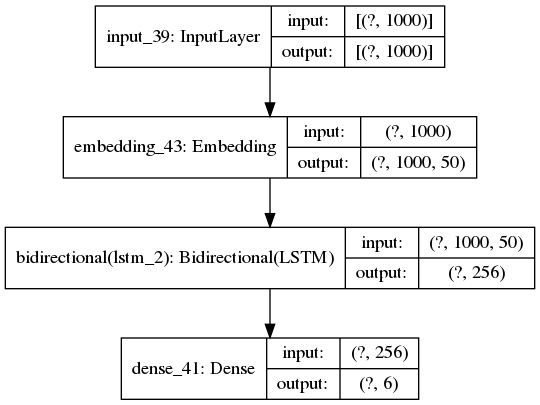

In [123]:
plot_model(model, show_shapes=True, show_layer_names=True)

## RCNN
### 定义网络结构

In [28]:
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, Lambda, Concatenate, Conv1D, GlobalMaxPooling1D


class RCNN(object):
    def __init__(self, maxlen, input_dim, output_dim,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input_current = Input((self.maxlen,))
        input_left = Input((self.maxlen,))
        input_right = Input((self.maxlen,))

        embedder = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen)
        embedding_current = embedder(input_current)
        embedding_left = embedder(input_left)
        embedding_right = embedder(input_right)

        x_left = SimpleRNN(128, return_sequences=True)(embedding_left)
        x_right = SimpleRNN(128, return_sequences=True, go_backwards=True)(embedding_right)
        x_right = Lambda(lambda x: K.reverse(x, axes=1))(x_right)
        x = Concatenate(axis=2)([x_left, embedding_current, x_right])

        x = Conv1D(64, kernel_size=1, activation='tanh')(x)
        x = GlobalMaxPooling1D()(x)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=[input_current, input_left, input_right], outputs=output)
        return model

### 训练

In [26]:
x_train_current = x_train
x_train_left = np.hstack([np.expand_dims(x_train[:, 0], axis=1), x_train[:, 0:-1]])
x_train_right = np.hstack([x_train[:, 1:], np.expand_dims(x_train[:, -1], axis=1)])
x_test_current = x_test
x_test_left = np.hstack([np.expand_dims(x_test[:, 0], axis=1), x_test[:, 0:-1]])
x_test_right = np.hstack([x_test[:, 1:], np.expand_dims(x_test[:, -1], axis=1)])

In [30]:
model = RCNN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./rcnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1350/1350 [==============================] - 62s 46ms/sample - loss: 1.8307 - accuracy: 0.1570 - val_loss: 1.8248 - val_accuracy: 0.1711
Epoch 2/4
1350/1350 [==============================] - 64s 47ms/sample - loss: 1.8242 - accuracy: 0.1548 - val_loss: 1.8034 - val_accuracy: 0.1822
Epoch 3/4
1350/1350 [==============================] - 61s 45ms/sample - loss: 1.8115 - accuracy: 0.1600 - val_loss: 1.8123 - val_accuracy: 0.1667
Epoch 4/4
1350/1350 [==============================] - 62s 46ms/sample - loss: 1.7941 - accuracy: 0.1911 - val_loss: 1.8024 - val_accuracy: 0.1778


### 指标

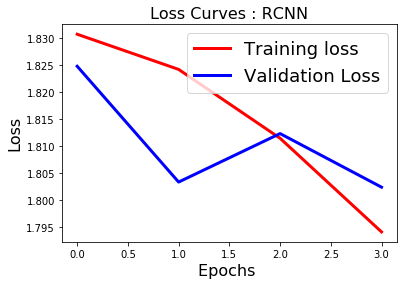

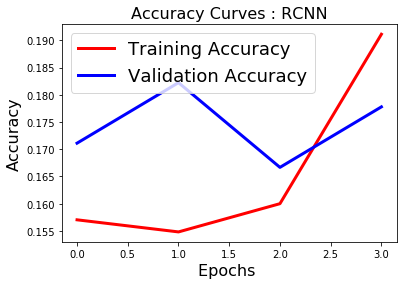

In [41]:
plot_loss_acc(history,'RCNN')

### 模型结构

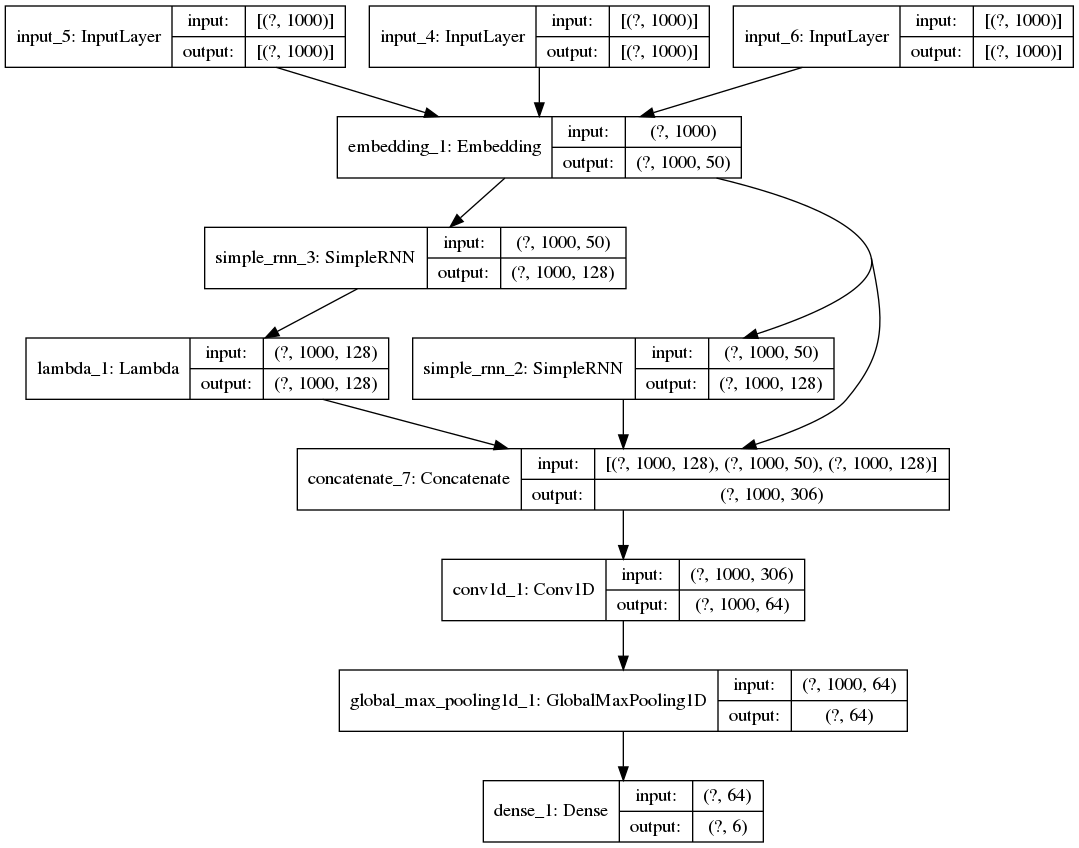

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Attention-biRNN
### 定义网络结构

In [42]:
from tensorflow.keras import backend as K
#from tensorflow.python.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
#from keras.engine.topology import Layer

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [43]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM

class TextAttBiRNN(object):
    def __init__(self, maxlen, input_dim, output_dim,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))

        embedding = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen)(inputs)
        x = Bidirectional(LSTM(128, return_sequences=True))(embedding)  # LSTM or GRU
        x = Attention(self.maxlen)(x)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

### 训练

In [45]:
model = TextAttBiRNN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./attention_birnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1350/1350 [==============================] - 99s 74ms/sample - loss: 1.7952 - accuracy: 0.1674 - val_loss: 1.7888 - val_accuracy: 0.1578
Epoch 2/4
1350/1350 [==============================] - 102s 75ms/sample - loss: 1.7116 - accuracy: 0.2474 - val_loss: 1.6569 - val_accuracy: 0.2622
Epoch 3/4
1350/1350 [==============================] - 102s 76ms/sample - loss: 1.5745 - accuracy: 0.3215 - val_loss: 1.6503 - val_accuracy: 0.2444
Epoch 4/4
1350/1350 [==============================] - 101s 75ms/sample - loss: 1.5191 - accuracy: 0.3467 - val_loss: 1.7839 - val_accuracy: 0.2867


### 指标

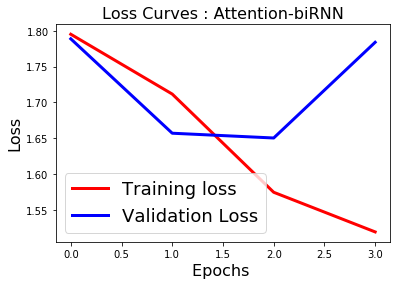

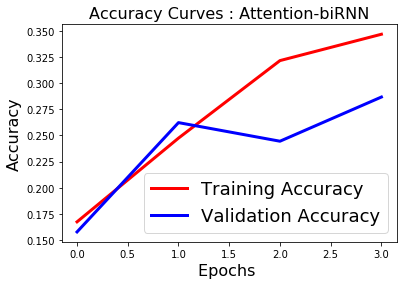

In [46]:
plot_loss_acc(history,'Attention-biRNN')

### 模型结构

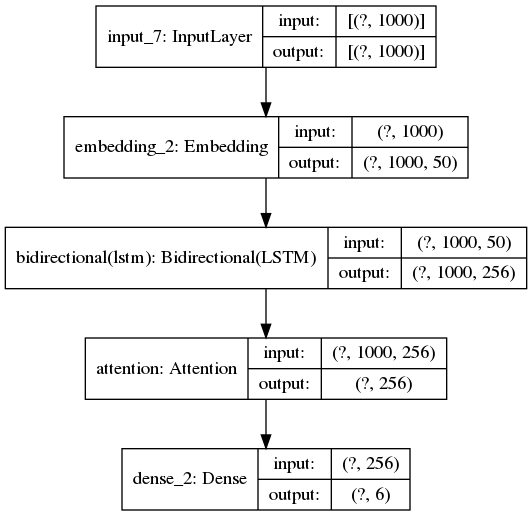

In [47]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 50)          250050    
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 256)         183296    
_________________________________________________________________
attention (Attention)        (None, 256)               1256      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 436,144
Trainable params: 436,144
Non-trainable params: 0
_________________________________________________________________


## HAN
### 定义网络机构

In [50]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, TimeDistributed

class HAN(object):
    def __init__(self, maxlen_sentence, maxlen_word, input_dim, output_dim,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen_sentence = maxlen_sentence
        self.maxlen_word = maxlen_word
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        # Word part
        input_word = Input(shape=(self.maxlen_word,))
        x_word = Embedding(self.input_dim, self.output_dim, input_length=self.maxlen_word)(input_word)
        x_word = Bidirectional(LSTM(128, return_sequences=True))(x_word)  # LSTM or GRU
        x_word = Attention(self.maxlen_word)(x_word)
        model_word = Model(input_word, x_word)

        # Sentence part
        input = Input(shape=(self.maxlen_sentence, self.maxlen_word))
        x_sentence = TimeDistributed(model_word)(input)
        x_sentence = Bidirectional(LSTM(128, return_sequences=True))(x_sentence)  # LSTM or GRU
        x_sentence = Attention(self.maxlen_sentence)(x_sentence)

        output = Dense(self.class_num, activation=self.last_activation)(x_sentence)
        model = Model(inputs=input, outputs=output)
        return model

### 训练

In [124]:
X,y=zip(*d)

X=sequence.pad_sequences(X, input_length=400)
X=X.reshape(-1,25,16)
y=to_categorical(y)

x_train,x_test,y_train,y_test=train_test_split(X,y)

In [126]:
model = HAN(maxlen, input_dim, output_dim,class_num).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./han_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1350/1350 [==============================] - 21s 16ms/sample - loss: 1.7676 - accuracy: 0.1889 - val_loss: 1.6686 - val_accuracy: 0.2578
Epoch 2/4
1350/1350 [==============================] - 16s 12ms/sample - loss: 1.5664 - accuracy: 0.2652 - val_loss: 1.6660 - val_accuracy: 0.2778
Epoch 3/4
1350/1350 [==============================] - 17s 13ms/sample - loss: 1.3462 - accuracy: 0.3630 - val_loss: 1.8988 - val_accuracy: 0.2867
Epoch 4/4
1350/1350 [==============================] - 17s 13ms/sample - loss: 1.0925 - accuracy: 0.4874 - val_loss: 2.0590 - val_accuracy: 0.3178


### 指标

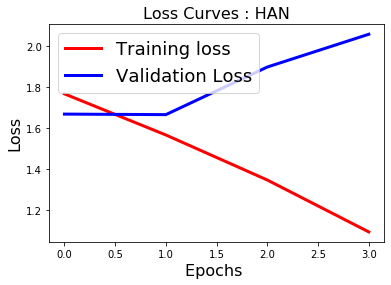

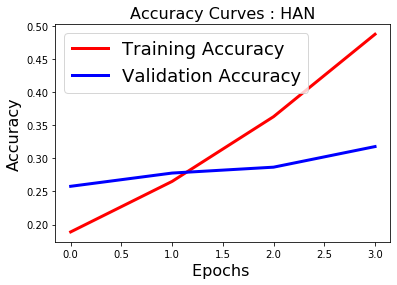

In [127]:
plot_loss_acc(history,'HAN')

### 模型结构

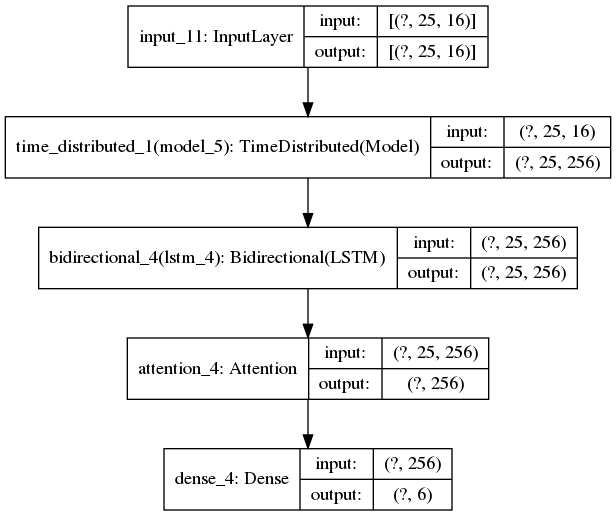

In [128]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [129]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 25, 16)]          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 256)           2683618   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 25, 256)           394240    
_________________________________________________________________
attention_4 (Attention)      (None, 256)               281       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 3,079,681
Trainable params: 3,079,681
Non-trainable params: 0
_________________________________________________________________
